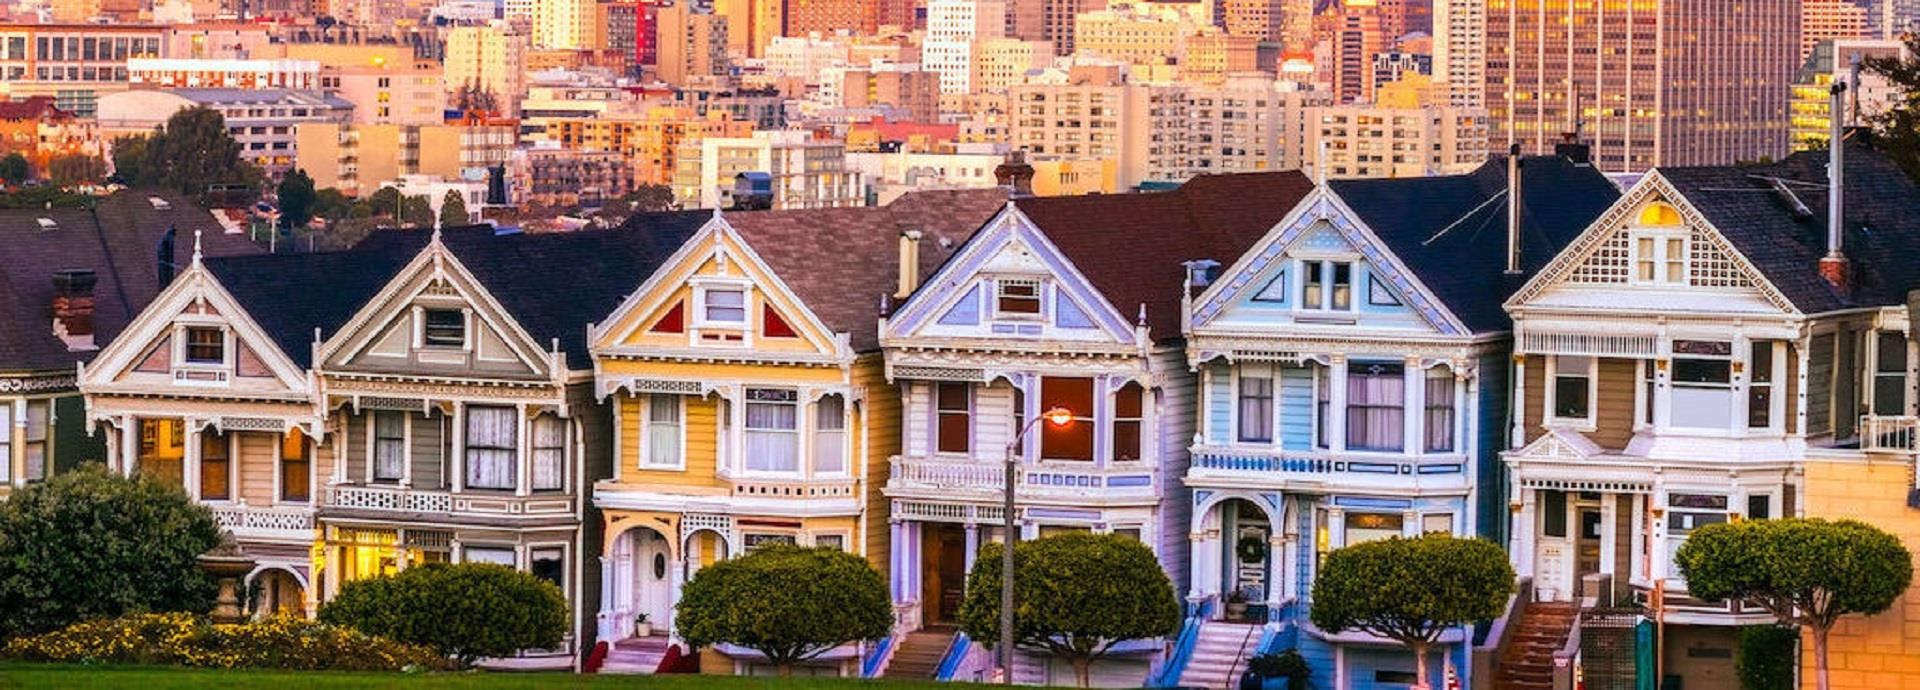

# Zillow Times Series Analysis 
Author: Jennifer Ha
***

## Overview
With their recent susscessful housing investment in New York, our client Stellar Property Group seeks to expand their listings in California, which happens to be the other state with the most Fortune 500 company headquarters besides New York. Our client believes the trends and contributing factors that they saw in New York, especially the continued job growth will continue to increase the home values. The team is looking for recommendations on top 5 zipcodes to invest in California, and this analysis will also provide them with short-term vs. long-term investment decisions.

## Business Understanding

The goal of this analysis is to identify the top 5 zipcodes for our client to invest in. We have plenty of data to work with but I wanted to be mindful of some finanacial events that happened in the past (e.g. Housing Bubble and Great Despression). Insead of removing these data, I used the [coefficient of variantion](https://www.investopedia.com/terms/c/coefficientofvariation.asp) to take risk into consideration. This is a very common method being used in finance to determine how much volatility, or risk, is assumed in comparison to the amount of retrun expected from investments. I've also selected data in 30-70 quartile to add some variation.

After running some simple time series models, we will use auto_arima on SARIMAX model to determine the best performing parameters for each zipcode. The performance is evaluated using p-value and RMSE, and the recommendation is made based on the predicted ROIs in 1 year, 3 year, 5 year, and 10 yaer. 

## Data
The original dataset for this analyisis consists of ~14,726 rows and 272 variables of median monthly housing sales prices from April 1996 through 2018 as repored by Zillow. Each row represents a unique zip code indexed with RegioinID, and  contains location info and median housing sales prices for each month.

In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import time
from functions import *

import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima

from sklearn import metrics
from sklearn.metrics import mean_squared_error

ERROR! Session/line number was not unique in database. History logging moved to new session 463


In [2]:
# Import data into a dataframe and preview 
df = pd.read_csv('data/zillow_data.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#Check for duplicates
df.RegionID.duplicated().sum()

0

In [4]:
# Keep CA state only
df_ca = df.loc[df['State']=='CA'].reset_index()

# Drop unnecessary columns
df_ca.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)

df_ca.info()
df_ca.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 2.5+ MB


,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [5]:
# Rename "RegionName" to "Zipcode" 
df_ca = df_ca.rename(columns={'RegionName': 'ZipCode'})

df_ca.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


Our client mainly wants to focus on CA. let's drop the rest.

In [6]:
#Reshape from wide to long format
#Code from Project 4 Start Notebook
def melt_data(df):
    melted = pd.melt(df, 
                     id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [7]:
melted_df = melt_data(df_ca)
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318744 entries, 0 to 324359
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ZipCode     318744 non-null  int64         
 1   City        318744 non-null  object        
 2   State       318744 non-null  object        
 3   Metro       308142 non-null  object        
 4   CountyName  318744 non-null  object        
 5   Date        318744 non-null  datetime64[ns]
 6   value       318744 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 19.5+ MB


In [8]:
#Convert data type to object for ZipCode column
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y/%m')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

melted_df.info
melted_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,222400.0


As mentioned, we will only include California data for this analysis. I've thought about manipuating the data by removing some for the major finanacial events such as the [Housing Bubble and Great Depression](https://en.wikipedia.org/wiki/Great_Recession). Instead, I've played with selecting the data using quartiles and coefficient of variation. 


For this dataset, we will only include data from CA. Because of the housing market crash, any modelling that uses only recent years may be misleading. We will use every value from 1996 to 2018 so we can have the most accurate picture of home values in CA through the years.

## Exploratory Data Analysis (EDA)
Let's get a better understanding of the data we are working with. We will also indetify top 10 zipcodes for analysis before making the decision on final top 5.

In [9]:
print('Average CA home value' ,round(melted_df['value'].mean()))

Average CA home value 457429


### Average Home Value by Month and Year

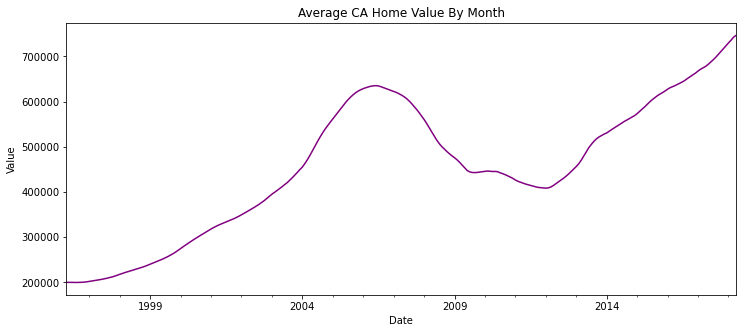

In [10]:
# Resample data by month
month_data = melted_df['value'].resample('MS').mean()
month_data = month_data.fillna(month_data.bfill())
month_data.plot(figsize=(12,5), color='purple')
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()

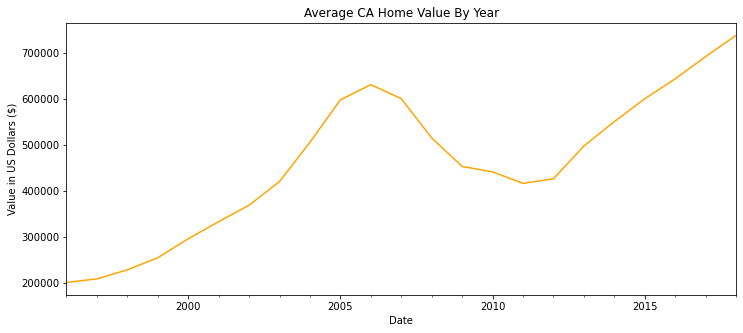

In [11]:
# Resample data by month
yr_data = melted_df['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()

### Top 10 Metro & County (mean value)

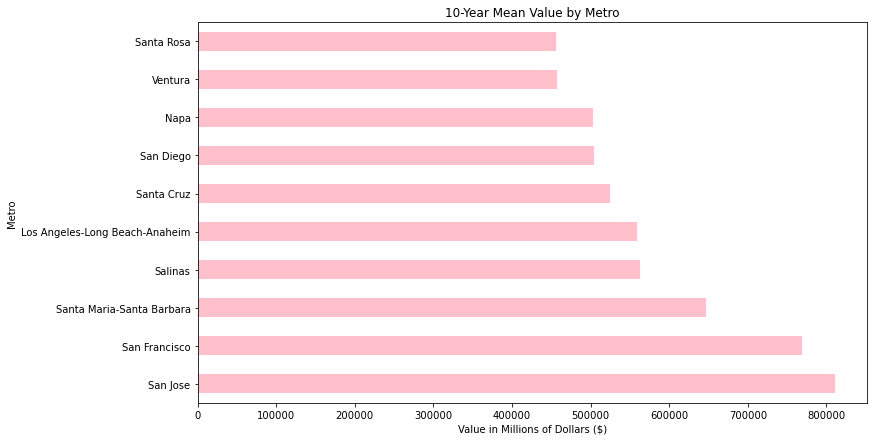

In [12]:
#Get Mean Home Value by metro
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head(10)

#Plot Mean HOme Value by Metro
metro.plot.barh(figsize = (12,7),color='pink')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

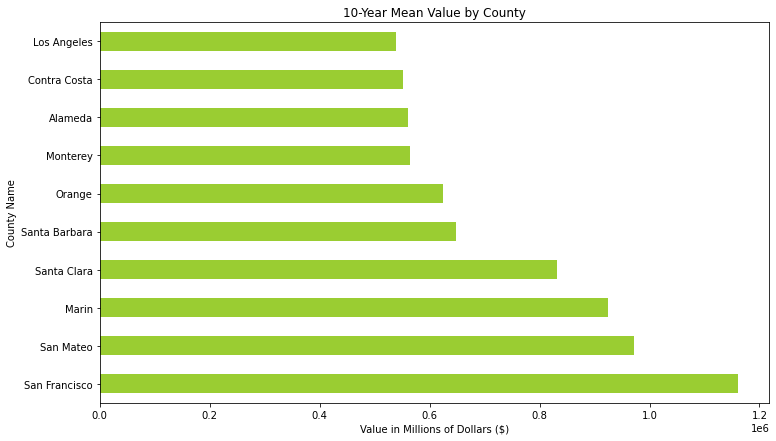

In [13]:
#Get Mean Home Value by County
county = melted_df.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

#Plot Mean Home Value by County
county.plot.barh(figsize = (12,7),color='yellowgreen')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

### Top 10 Zipcode ( mean ROI)
As mentioned we will use coefficient of variation (CV) to build risk profile and assume above 50% is risky. This is a very commen method used by many investors and analysts in finance to determine the volatility and risk when making investments. The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.

In [14]:
#Calculate average home value in the DataFrame
df_ca['yr_avg']=df_ca.iloc[:,-60:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 2 decile above the median and 2 deciles below.
print(df_ca['yr_avg'].describe(),'\n')

#Calculate the 70% cutoff value (2 decile above).
q_70 = df_ca['yr_avg'].quantile(q=0.70)
print(f'Average Value 70% cutoff value: {round(q_70,2)}')

#Calculate the 30% cutoff value (2 deciles below).
q_30 = df_ca['yr_avg'].quantile(q=0.30)
print(f'Average Value 30% cutoff value: {round(q_30,2)}')

#Get data frame with selected zipcodes.
df_avg = df_ca[(df_ca['yr_avg']<q_70) & (df_ca['yr_avg']>q_30)]
print(f'Amount of zipcodes: {len(df_avg)}')

count    1.224000e+03
mean     6.146968e+05
std      5.553401e+05
min      5.477833e+04
25%      2.826767e+05
50%      4.664775e+05
75%      7.432292e+05
max      5.319428e+06
Name: yr_avg, dtype: float64 

Average Value 70% cutoff value: 654150.17
Average Value 30% cutoff value: 313131.83
Amount of zipcodes: 490


In [15]:
#Calculate historical return on investment
df_avg['ROI'] = (df_avg['yr_avg']/df_avg['1996-04'])-1

#Calculate standard deviation of monthly values
df_avg['std'] = df_avg.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_avg['mean'] = df_avg.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_avg['CV'] = df_avg['std']/df_avg['mean']

#Show calculated values
df_avg[['ZipCode','std','mean','ROI','CV','CountyName']].head()

,ZipCode,std,mean,ROI,CV,CountyName
1,90250,138601.533036,365464.150943,2.262240,0.379248,Los Angeles
2,94565,104006.852657,263874.339623,1.334291,0.394153,Contra Costa
7,90044,97293.744047,243829.811321,1.686262,0.399023,Los Angeles
8,90805,108971.123756,281955.471698,1.918213,0.386483,Los Angeles
9,95630,106331.603220,373722.264151,1.513737,0.284520,Sacramento


In [16]:

#find out the top 10 couties with highest ROI
grp_county = df_avg.groupby('CountyName', group_keys=False).sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

# sorted(round(grouped_county,2), reverse=True)[:10]

CountyName
Los Angeles       313.935844
San Diego         113.669953
Orange             70.569764
Riverside          41.097313
Ventura            32.937638
Sacramento         32.498056
San Bernardino     31.662873
Alameda            29.279048
Placer             27.415028
Sonoma             26.812512
Name: ROI, dtype: float64

In [17]:
#top 10 counties with highest ROI before considering risk factor CV
grp_county.sort_values(ascending=False)[:10].keys()

Index(['Los Angeles', 'San Diego', 'Orange', 'Riverside', 'Ventura',
       'Sacramento', 'San Bernardino', 'Alameda', 'Placer', 'Sonoma'],
      dtype='object', name='CountyName')

In [18]:
#Descriptive statistics of coefficients of variance.
print(df_avg.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_avg.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 10 counties with highest ROIs within the firms risk profile.
df_top10 = df_avg[df_avg['CV']<upper_cv].sort_values('ROI', axis=0, ascending=False)

#find out the top 10 couties with highest ROI
grp_county = df_top10.groupby('CountyName').sum()['ROI']
grp_county.sort_values(ascending=False)[:10]

count    490.000000
mean       0.342695
std        0.045802
min        0.062004
25%        0.316948
50%        0.343743
75%        0.367369
max        0.496292
Name: CV, dtype: float64

CV upper limit: 0.35277120068469897


CountyName
San Diego          81.000270
Los Angeles        69.132190
Orange             29.551015
Riverside          28.391854
Placer             27.415028
Sonoma             26.812512
San Luis Obispo    24.860144
Sacramento         24.044008
Ventura            22.830799
Alameda            14.629467
Name: ROI, dtype: float64

In [19]:
top10_county = list(grp_county.sort_values(ascending=False)[:10].index)
top10_county

['San Diego',
 'Los Angeles',
 'Orange',
 'Riverside',
 'Placer',
 'Sonoma',
 'San Luis Obispo',
 'Sacramento',
 'Ventura',
 'Alameda']

In [20]:
df_top10 = df_top10.loc[df_top10['CountyName'].isin(top10_county)]
df_top10.shape

(204, 275)

In [21]:
#Check how many zip code are in each county
df_top10['CountyName'].value_counts()

San Diego          44
Los Angeles        40
Riverside          21
Placer             18
Sacramento         17
Sonoma             16
Orange             14
San Luis Obispo    13
Ventura            13
Alameda             8
Name: CountyName, dtype: int64

In [22]:
#Get city and state names for each zip code
ziplist = []
roi_top10 = {}

for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    ZipCode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    ROI = (df_top10[df_top10['CountyName']==i].mean()['ROI'])*100
    
    ziplist.append(ZipCode)
    roi_top10[i] = ROI
    print(f'County: {i}, ROI: {ROI} \nCity: {City}, Zipcode: {ZipCode}, Metro: {Metro}\n')

County: San Diego, ROI: 184.09152301937232 
City: San Diego, Zipcode: 92101, Metro: San Diego

County: Los Angeles, ROI: 181.9268168820959 
City: Monterey Park, Zipcode: 91754, Metro: Los Angeles-Long Beach-Anaheim

County: Orange, ROI: 211.07867725013816 
City: Orange, Zipcode: 92866, Metro: Los Angeles-Long Beach-Anaheim

County: Riverside, ROI: 135.1993034060613 
City: Norco, Zipcode: 92860, Metro: Riverside

County: Placer, ROI: 152.30571218229363 
City: Homewood, Zipcode: 96141, Metro: Sacramento

County: Sonoma, ROI: 167.57819905750162 
City: Geyserville, Zipcode: 95441, Metro: Santa Rosa

County: San Luis Obispo, ROI: 191.23187948750837 
City: San Luis Obispo, Zipcode: 93405, Metro: San Luis Obispo

County: Sacramento, ROI: 141.4353428789623 
City: Sacramento, Zipcode: 95818, Metro: Sacramento

County: Ventura, ROI: 175.6215318542781 
City: Ventura, Zipcode: 93003, Metro: Ventura

County: Alameda, ROI: 208.99238937264514 
City: Castro Valley, Zipcode: 94546, Metro: San Francisco

Our analysis shows that all top 10 counties saw ROI above 150% since April 1996. Out of those counties, Contra Costa, Santa Clara, and Ornage counties had the highest ROI above 200%

## Preprocessing

In [23]:
ziplist

[92101, 91754, 92866, 92860, 96141, 95441, 93405, 95818, 93003, 94546]

In [24]:
ziplist = ['92101', '91754', '92866', '92860', '96141', '95441', '93405',
           '95818', '93003', '94546']

In [25]:
#create a dictionary for each zipcode
ts = {}
for zc in ziplist:
    temp_df = melted_df.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [26]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,92101,91754,92866,92860,96141,95441,93405,95818,93003,94546
Date,,,,,,,,,,
1996-04-01,147000.0,188600.0,173700.0,162900.0,170600.0,223800.0,181000.0,144000.0,182900.0,202100.0
1996-05-01,147400.0,188000.0,173600.0,162200.0,171800.0,222900.0,181700.0,144300.0,182700.0,201600.0
1996-06-01,147700.0,187400.0,173500.0,161500.0,172900.0,221900.0,182500.0,144500.0,182400.0,201100.0
1996-07-01,148100.0,186900.0,173500.0,160800.0,174000.0,220900.0,183300.0,144500.0,182200.0,200600.0
1996-08-01,148500.0,186500.0,173600.0,160200.0,175100.0,220000.0,184300.0,144600.0,182100.0,200200.0


In [27]:
zip_1 = ziplist[0]

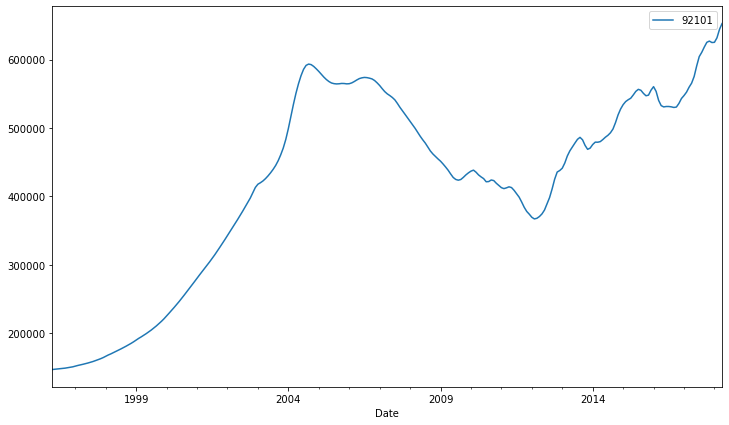

In [28]:
ts_zip1 = ts_df[zip_1].copy()
ax = ts_zip1.plot(figsize=(12,7))
ax.legend()
plt.show()

### Train-Test Split

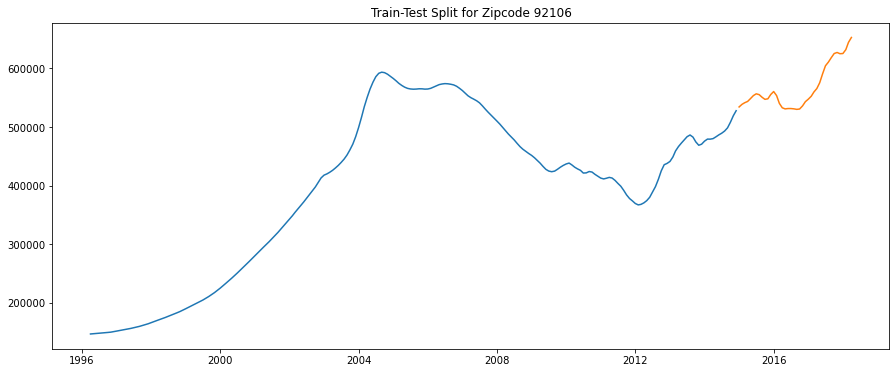

In [29]:
train_size = 0.85 
split_idx = round(len(ts_zip1)* train_size)
split_idx

## Split
train = ts_zip1.iloc[:split_idx]
test = ts_zip1.iloc[split_idx:]

## Visualize split
# Looking at big city dataset as an example
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(train)
ax.plot(test)
ax.set_title('Train-Test Split for Zipcode 92106');

## Model 1: Random Walk Model

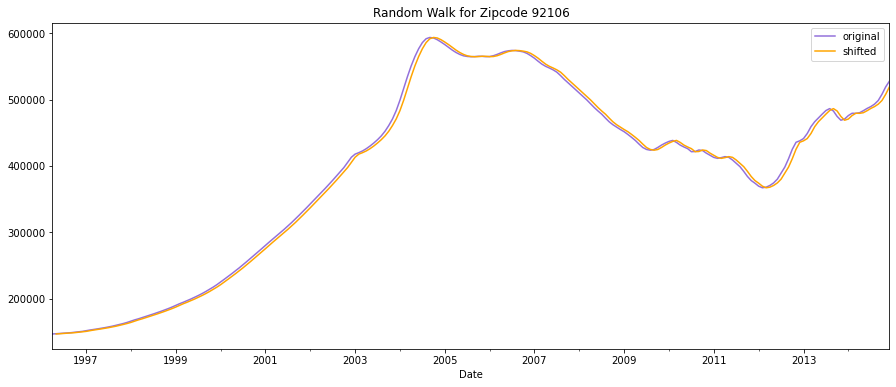

In [30]:
train = ts_zip1.iloc[:split_idx]
random_walk = train.shift(1)

fig, ax = plt.subplots(figsize=(15,6))

train[0:270].plot(ax=ax, c='mediumpurple', label='original')
random_walk[0:270].plot(ax=ax, c='orange', label='shifted')
ax.set_title('Random Walk for Zipcode 92106')
ax.legend();

In [31]:
# Calculate Root Mean Squared Error for above data 
residuals = random_walk - train
rmse = mean_squared_error(train[1:], random_walk.dropna())
rmse # use as benchmark for our modeling process and this scary!

27141651.785714287

## Model 2: ARIMA Model

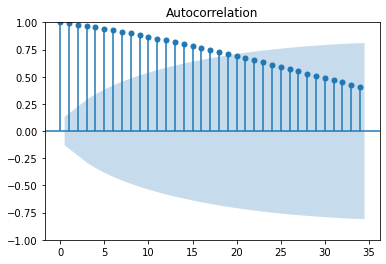

In [32]:
plot_acf(train,lags=34);

The above autocorrelation shows that there is corrletation between lags up about 20 weeks back. Due to the strong correlation with higher order lags, I will check if first difference makes them any better.

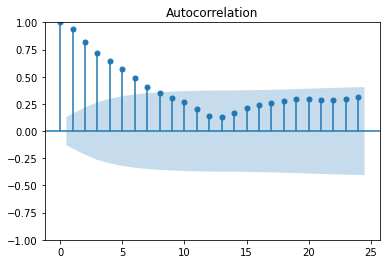

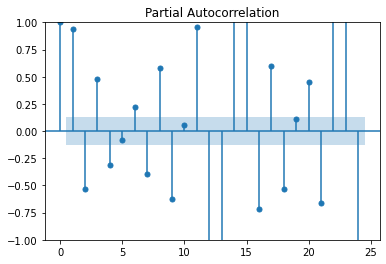

In [33]:
#(0,1,0) model results
plot_acf(train.diff().dropna());
plot_pacf(train.diff().dropna());

ACF plot looks better (still not ideal) and tells us that there is a strong correlation with lag around 10. Also, our PACF shows an extremely different result where all lags are statiscally significant. 

Our first model did not do so well, and therefore, we will run more iterations below. We will explore ARIMAX and SARIMAX but I would like to try hand-manually selecting the parameter values based on the result above. Nothing is guaranteed but I'm hoping to see better results.

### Model 2: ARIMA Model Cont'd - Handpicking Hyperparameter Values

In [34]:
rmse_arima(train, 1, 1, 1)
aic_arima(train, 1, 1, 1)

10657.237647159529
4378.343678228663


In [35]:
rmse_arima(train, 2, 1, 1)
aic_arima(train, 2, 1, 1)

10817.862709288027
4423.638782519734


In [36]:
rmse_arima(train, 3, 1, 2)
aic_arima(train, 3, 1, 2)

10521.719771336077
5616.351884292737


In [37]:
rmse_arima(train, 5, 1, 5)
aic_arima(train, 5, 1, 5)

10466.847650847345
6010.843198045274


I imangined that this could be a fun excercise but the results are too disappointing. The last iteration shows that higher value for p and q parameters returns better results but not very promising. It actually seems all over the place, which leads to the conculsion that we should try running models using `auto_arima()`. We will first run a ARIMAX model and then SARIMAX model.

## Model 3: ARIMAX Model

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3944.941, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3948.154, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3943.351, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3945.051, Time=0.24 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3960.481, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3962.415, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3945.190, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.561 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1969.676
Date:                Fri, 29 Oct 2021   AIC                           3943.351
Time:                        13:33:09   BIC                           3950.165
Sample:                             0   HQIC                          3946.102
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0335      0.010      3.394      0.001       0.014       0.053
sigma2      2.722e+06   1.38e+05     19.727      0.000    2.45e+06    2.99e+06
===================================================================================
Ljung-Box (L1) (Q):                  42.82   Jarque-Bera (JB):               252.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              46.81   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

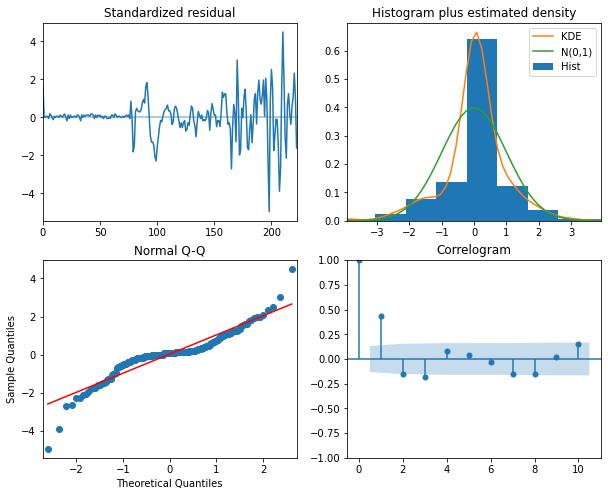

In [38]:
auto_model=auto_arima(train,start_p=0,start_q=0, seasonal=True, trace=True)
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(10,8));

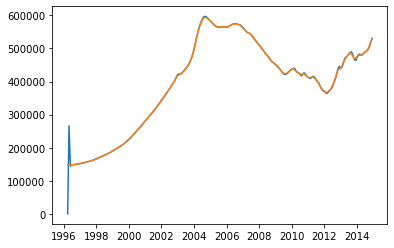

In [39]:
#Plotting training predictions
auto_model = ARIMA(train,order=(0,2,1)).fit()
y_hat_train = auto_model.predict(typ='levels')

fig, ax=plt.subplots()
ax.plot(y_hat_train);
ax.plot(train);

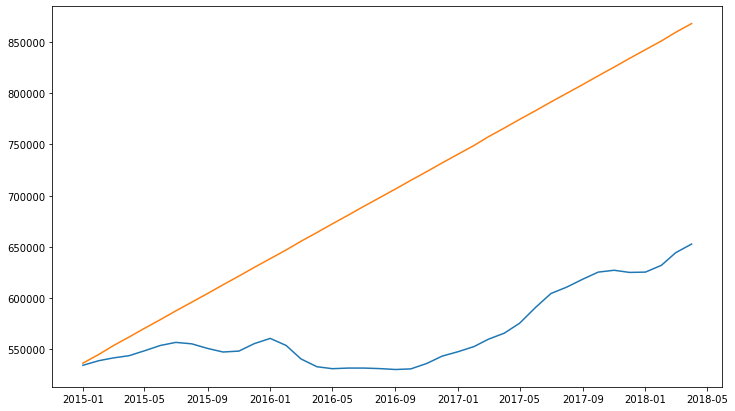

In [40]:
# Predicting on test data 
y_hat_test = auto_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(test);
ax.plot(y_hat_test);

In [41]:
rmse_arima(train, 0, 2, 1)

12688.446693783115


12688.446693783115

In [42]:
np.sqrt(mean_squared_error(test, y_hat_test))

153799.31495296195

In [43]:
forecast = auto_model.get_forecast(steps=len(test))

In [44]:
pred_df = forecast_to_df(forecast,ziplist[0])
pred_df.head()

,lower,upper,prediction
2015-01-01,532977.279335,539444.550837,536210.915086
2015-02-01,537394.033156,552049.627188,544721.830172
2015-03-01,540901.492346,565563.998169,553232.745258
2015-04-01,543636.061400,579851.259288,561743.660344
2015-05-01,545688.098186,594821.052672,570254.575429


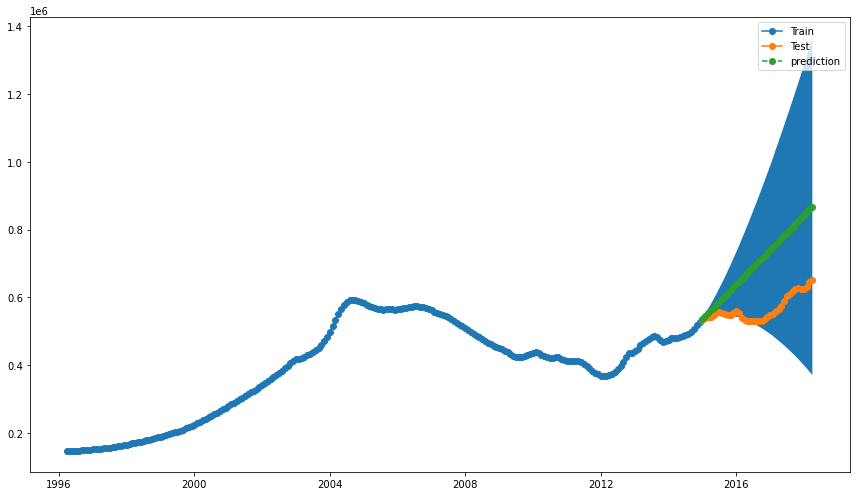

In [45]:
plot_train_test_pred(train,test,pred_df)

plt.show()

This ARIMA model with gridsearch worked pretty well as it was able to predict our test set close. I also like it is upward trending!

## Model 4: SARIMAX Model

In [48]:
# Running auto_arima
auto_arima(y=train, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3944.941, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3947.874, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3943.792, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3943.351, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3943.778, Time=0.30 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3945.051, Time=0.38 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=3960.481, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3948.154, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=3962.415, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=3945.190, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.956 seconds


ARIMA(order=(0, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [49]:
sarimax_model = SARIMAX(train,
                  order=(0, 2, 1),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

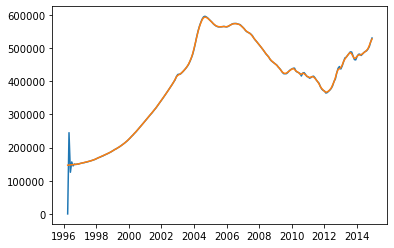

In [50]:
#Plotting training predictions
y_hat_train = sarimax_model.predict(typ='levels')

fig, ax=plt.subplots()
ax.plot(y_hat_train);
ax.plot(train);

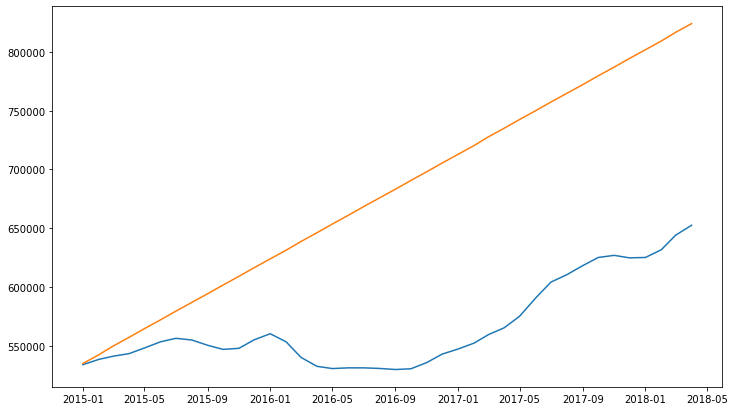

In [51]:
# Predicting on test data 
y_hat_test = sarimax_model.predict(start=test.index[0], end=test.index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(test);
ax.plot(y_hat_test);

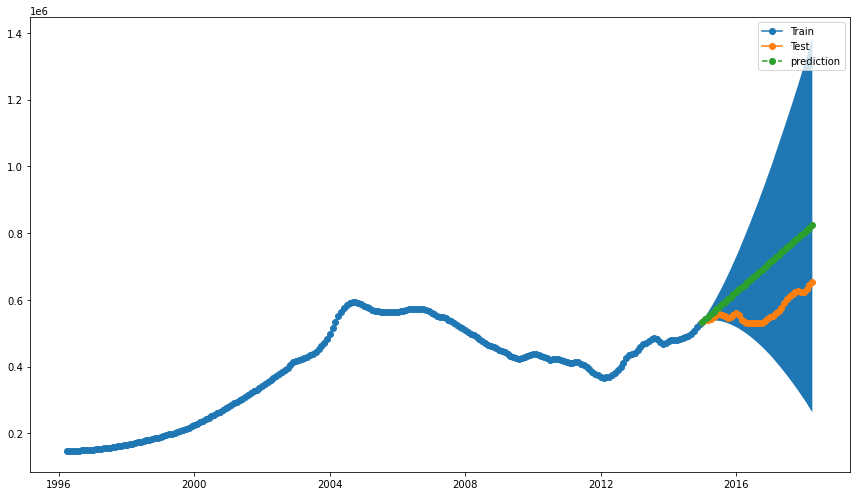

In [52]:
forecast = sarimax_model.get_forecast(steps=len(test))
pred_df = forecast_to_df(forecast,ziplist[0])

plot_train_test_pred(train,test,pred_df)
plt.show()

In [53]:
np.sqrt(mean_squared_error(test, y_hat_test))

128211.69142048349

Our SARIMAX model performed very well compared to ARIMAX model as the test RMSE shows. The prediction has changed and it actually looks off. However, given that our goal is to find out the top5 zipcodes that have the highest return on investment, we will move on with our SARMIAX model and run it on all zipcodes that selected with hyperparameter grid search.

92101
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3944.941, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3947.874, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3943.792, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3943.351, Time=0.09 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3943.778, Time=0.14 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3945.051, Time=0.23 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=3960.481, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3948.154, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=3962.415, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=3945.190, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.555 seconds
Predicted Mean Home Value:  866519.6
SARIMA model RMSE on train data: 12956.7
SARIMA model RMSE on test data: 152860.1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92101   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2402.061
Date:                Fri, 29 Oct 2021   AIC                           4808.121
Time:                        13:35:54   BIC                           4815.266
Sample:                    04-01-1996   HQIC                          4810.993
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0484      0.007      6.748      0.000       0.034       0.062
sigma2      3.546e+06   1.25e+05     28.369      0.000     3.3e+06    3.79e+06
===================================================================================
Ljung-Box (L1) (Q):                  36.26   Jarque-Bera (JB):               280.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.11   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

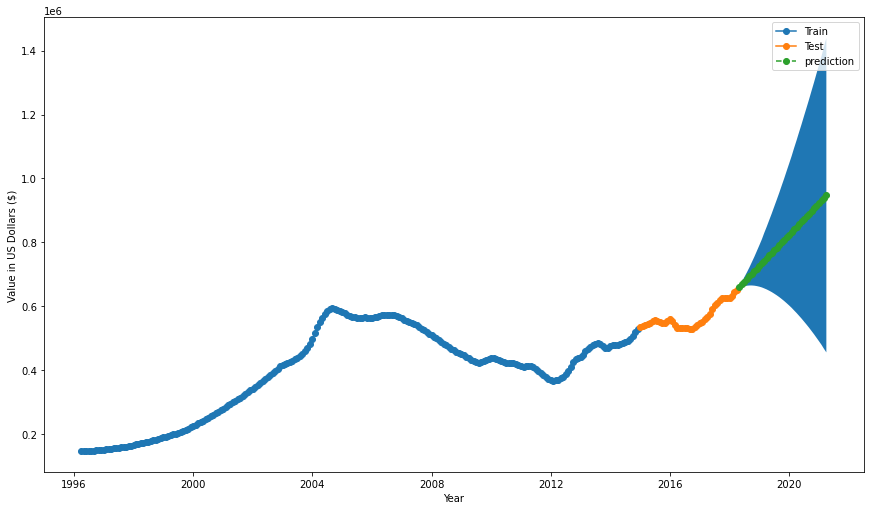

------------------------------------------------------------

91754
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4340.074, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4342.407, Time=0.43 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4327.156, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4379.281, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4327.501, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4329.134, Time=0.21 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4327.251, Time=0.15 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=4330.924, Time=0.92 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4339.328, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4298.549, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4297.224, Time=0.23 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4298.782, Time=0.72 sec
 ARIMA(1,1,1)(1,0,1)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  91754   No. Observations:                  265
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2535.133
Date:                Fri, 29 Oct 2021   AIC                           5078.266
Time:                        13:36:07   BIC                           5092.570
Sample:                    04-01-1996   HQIC                          5084.014
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.002    538.074      0.000       0.996       1.003
ma.L1         -0.9154      0.005   -166.633      0.000      -0.926      -0.905
ma.L2         -0.0801      0.007    -11.846      0.000      -0.093      -0.067
sigma2      1.268e+07   2.25e-11   5.64e+17      0.000    1.27e+07    1.27e+07
===================================================================================
Ljung-Box (L1) (Q):                 209.27   Jarque-Bera (JB):                52.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  4e+33. Standard errors may be unstable.
"""

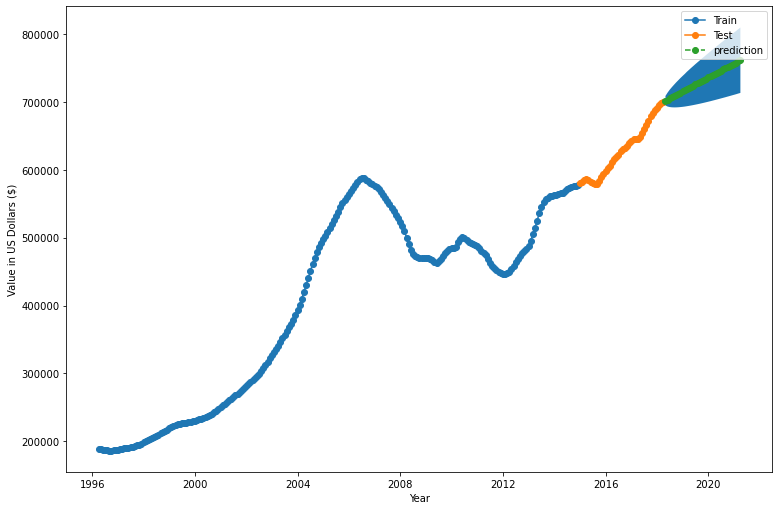

------------------------------------------------------------

92866
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3821.859, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3826.169, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3823.824, Time=0.17 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3823.457, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3823.417, Time=0.10 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3826.532, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3824.767, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3822.256, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3825.159, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=3823.814, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.760 seconds
Predicted Mean Home Value:  707500.0
SARIMA model RMSE on train data: 14371.3
SARIMA model RMSE on test data: 9281.8


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92866   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2257.028
Date:                Fri, 29 Oct 2021   AIC                           4516.056
Time:                        13:36:08   BIC                           4519.628
Sample:                    04-01-1996   HQIC                          4517.491
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.653e+06   5.77e+04     28.676      0.000    1.54e+06    1.77e+06
===================================================================================
Ljung-Box (L1) (Q):                  29.84   Jarque-Bera (JB):              1184.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.39   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

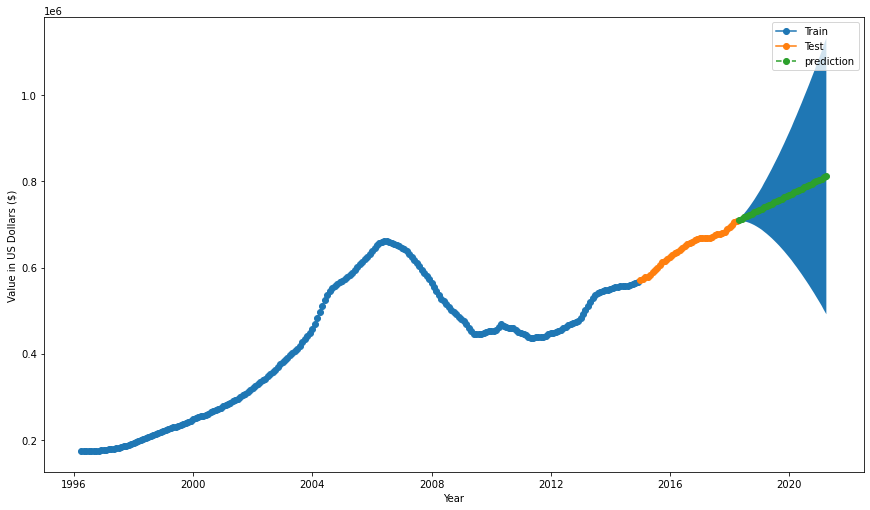

------------------------------------------------------------

92860
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3658.074, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3664.167, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3659.634, Time=0.21 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3660.210, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3659.944, Time=0.19 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3665.041, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3657.748, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3659.611, Time=0.13 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3665.050, Time=0.25 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=3659.661, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3659.525, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3657.770, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=3661.678, Time=0.27 sec
 ARIMA(1,2,0)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  92860   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2172.825
Date:                Fri, 29 Oct 2021   AIC                           4349.650
Time:                        13:36:10   BIC                           4356.794
Sample:                    04-01-1996   HQIC                          4352.521
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0238      0.010      2.400      0.016       0.004       0.043
sigma2      8.699e+05   5.71e+04     15.231      0.000    7.58e+05    9.82e+05
===================================================================================
Ljung-Box (L1) (Q):                  37.99   Jarque-Bera (JB):                26.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              23.99   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

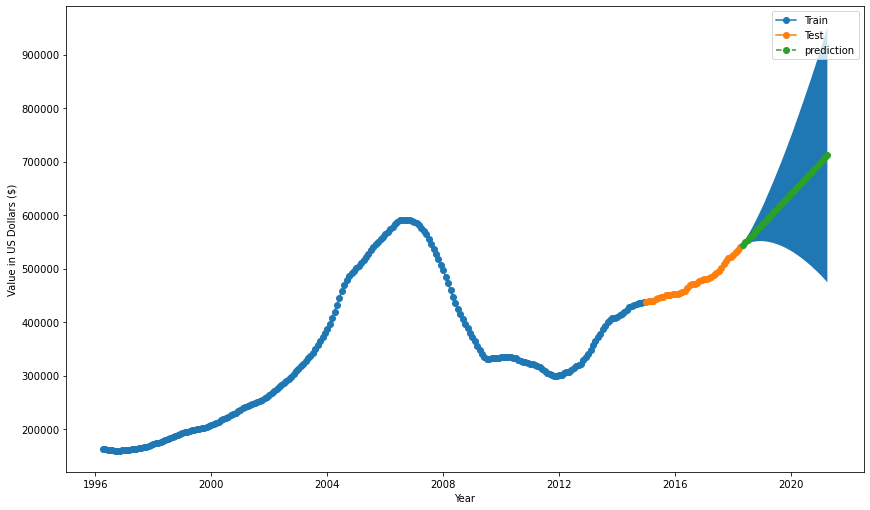

------------------------------------------------------------

96141
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=4226.293, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=4229.227, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=4242.484, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=4228.142, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=4231.172, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=4232.096, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=4227.556, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=4224.339, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=4242.499, Time=0.06 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=4243.427, Time=0.21 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=4236.089, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=4241.743, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  96141   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2514.119
Date:                Fri, 29 Oct 2021   AIC                           5032.239
Time:                        13:36:11   BIC                           5039.383
Sample:                    04-01-1996   HQIC                          5035.110
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0535      0.007      7.676      0.000       0.040       0.067
sigma2      7.806e+06   7.12e-12    1.1e+18      0.000    7.81e+06    7.81e+06
===================================================================================
Ljung-Box (L1) (Q):                  35.42   Jarque-Bera (JB):                68.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.16   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

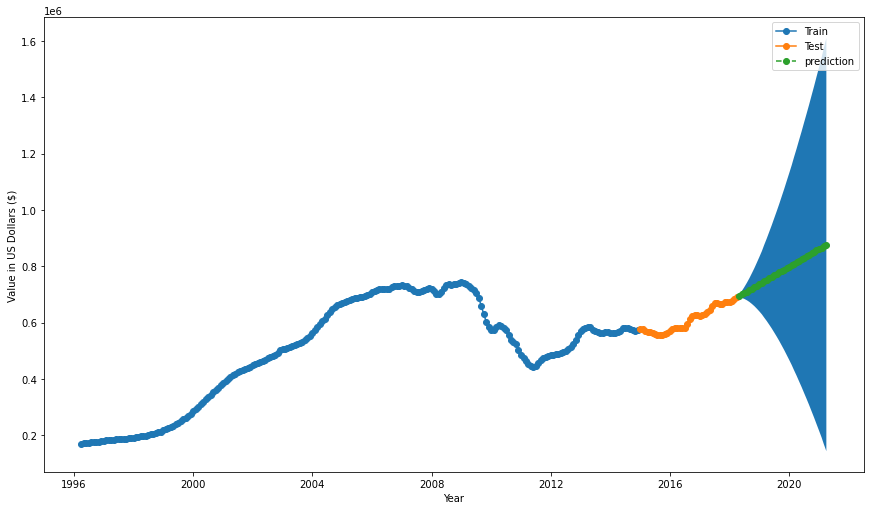

------------------------------------------------------------

95441
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4498.060, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4487.675, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4486.656, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4517.258, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4484.675, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4486.646, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4488.520, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4463.102, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4464.967, Time=0.58 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4464.962, Time=0.56 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=4517.500, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4485.762, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=4464.841, Time=0.30 sec
 ARIMA(1,1,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  95441   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2646.406
Date:                Fri, 29 Oct 2021   AIC                           5298.811
Time:                        13:36:16   BIC                           5309.539
Sample:                    04-01-1996   HQIC                          5303.122
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8581      0.037     23.055      0.000       0.785       0.931
ma.L1         -0.7858      0.042    -18.521      0.000      -0.869      -0.703
sigma2      2.958e+07   2.55e-10   1.16e+17      0.000    2.96e+07    2.96e+07
===================================================================================
Ljung-Box (L1) (Q):                 161.06   Jarque-Bera (JB):                22.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.7e+33. Standard errors may be unstable.
"""

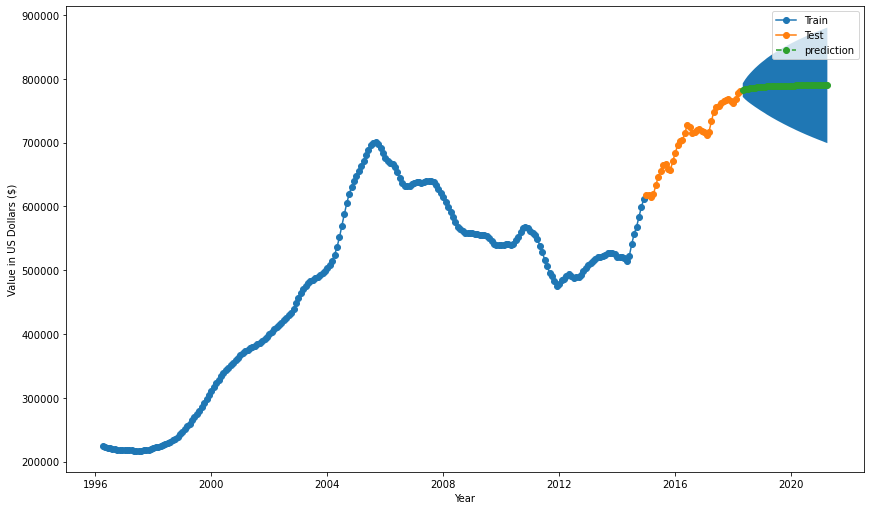

------------------------------------------------------------

93405
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3870.860, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3874.983, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3884.112, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3872.965, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3875.566, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3877.485, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3873.062, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3882.236, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3874.842, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=3872.840, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.358 seconds
Predicted Mean Home Value:  623600.0
SARIMA model RMSE on train data: 15405.1
SARIMA model RMSE on test data: 96871.5


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  93405   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2323.300
Date:                Fri, 29 Oct 2021   AIC                           4648.600
Time:                        13:36:17   BIC                           4652.173
Sample:                    04-01-1996   HQIC                          4650.036
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.737e+06    1.7e+05     16.100      0.000     2.4e+06    3.07e+06
===================================================================================
Ljung-Box (L1) (Q):                  18.94   Jarque-Bera (JB):                39.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              34.64   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

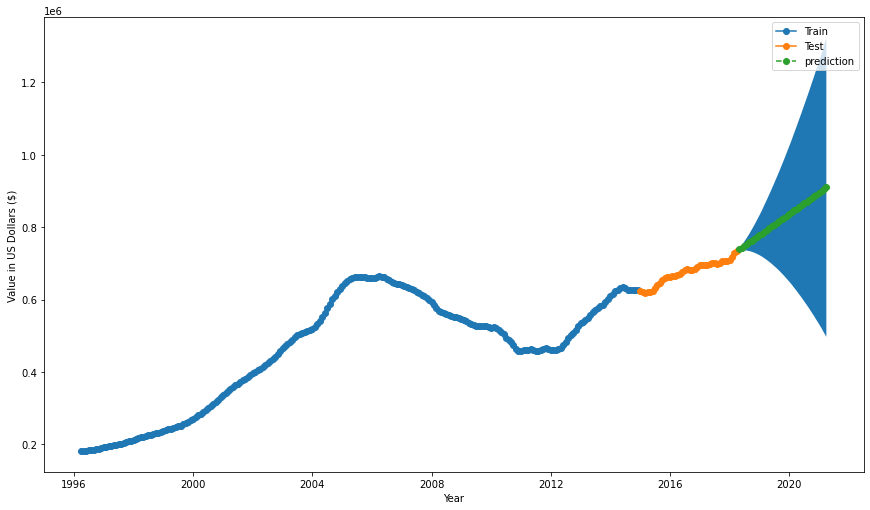

------------------------------------------------------------

95818
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3646.132, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3646.529, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3655.826, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3648.256, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3650.537, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3652.088, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3644.693, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3650.510, Time=0.06 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3651.833, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=3654.076, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3646.127, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3654.093, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  95818   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2193.726
Date:                Fri, 29 Oct 2021   AIC                           4391.452
Time:                        13:36:19   BIC                           4398.596
Sample:                    04-01-1996   HQIC                          4394.323
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0299      0.011      2.737      0.006       0.008       0.051
sigma2      1.019e+06   6.53e+04     15.612      0.000    8.91e+05    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                  30.66   Jarque-Bera (JB):                30.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              34.77   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

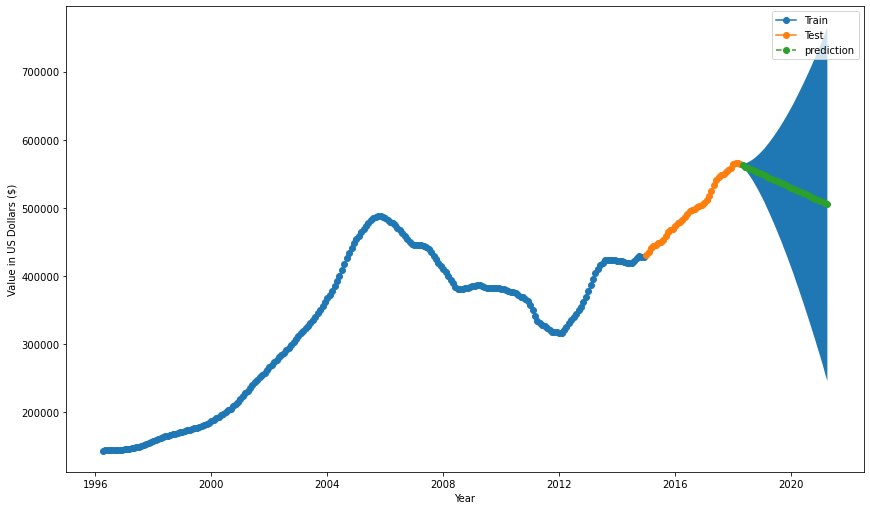

------------------------------------------------------------

93003
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3739.733, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3740.611, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3740.678, Time=0.18 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3741.574, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3741.511, Time=0.10 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3745.528, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3738.823, Time=0.05 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3751.046, Time=0.06 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3752.625, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=3758.283, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3740.025, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3738.891, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=3762.189, Time=0.10 sec
 ARIMA(1,2,0)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  93003   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2213.045
Date:                Fri, 29 Oct 2021   AIC                           4430.090
Time:                        13:36:21   BIC                           4437.234
Sample:                    04-01-1996   HQIC                          4432.961
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0271      0.007      3.672      0.000       0.013       0.042
sigma2      9.569e+05   5.75e+04     16.633      0.000    8.44e+05    1.07e+06
===================================================================================
Ljung-Box (L1) (Q):                  46.67   Jarque-Bera (JB):                10.29
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):              18.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

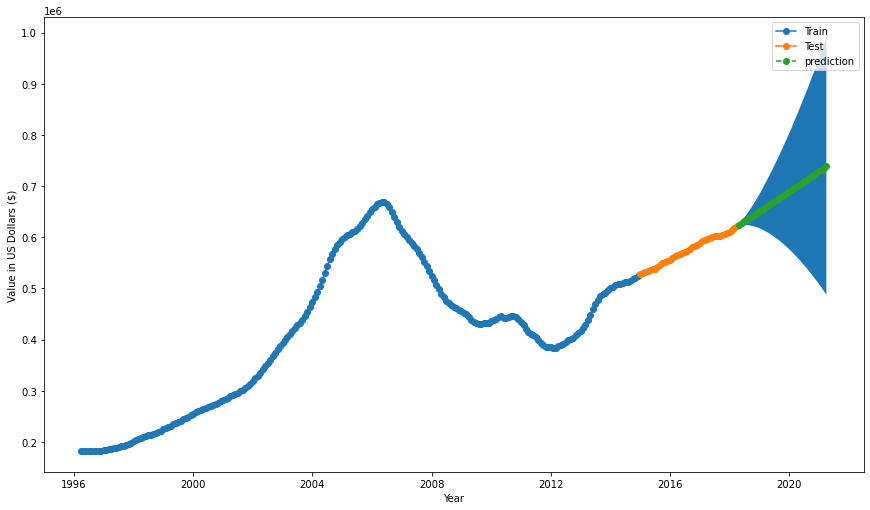

------------------------------------------------------------

94546
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4461.692, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4446.157, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4440.824, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4484.621, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4441.857, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4442.823, Time=0.19 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=4442.717, Time=0.20 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4440.853, Time=0.13 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=4444.701, Time=0.47 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4459.708, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4396.496, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(1,1,1)(0,0,2)[12] int

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              94546   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -2621.863
Date:                            Fri, 29 Oct 2021   AIC                           5251.726
Time:                                    13:36:34   BIC                           5266.030
Sample:                                04-01-1996   HQIC                          5257.474
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    705.032      0.000       0.997       1.003
ma.L1         -0.9991      0.017    -58.654      0.000      -1.032      -0.966
ma.S.L12       0.0532      0.011      4.686      0.000       0.031       0.076
sigma2      2.357e+07   3.56e-11   6.62e+17      0.000    2.36e+07    2.36e+07
===================================================================================
Ljung-Box (L1) (Q):                 239.66   Jarque-Bera (JB):                 9.21
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               5.40   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+33. Standard errors may be unstable.
"""

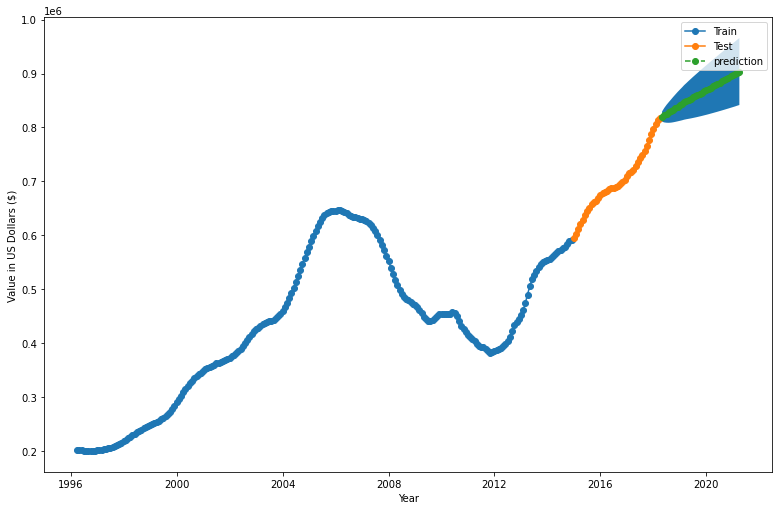

------------------------------------------------------------



In [55]:
RESULTS = {}

for zc in ziplist:
    print(zc)
    
    ## Make empty dict for district data
    zipcode_d = {}
    
    ## Copy Time Series
    ts_final = ts_df[zc].copy()
    
    ## Train Test Split Index
    train_size = 0.85
    split_idx = round(len(ts_df)* train_size)

    ## Split
    train = ts_final.iloc[:split_idx]
    test = ts_final.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(y=train, start_p=0, start_q=0, max_p=10, max_q=10,
                           start_P=0, start_Q=0, max_P=10, max_Q=10, m=12,
                           max_order=None,trace=True)
    sarimax_model = SARIMAX(ts_final,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = sarimax_model.get_forecast(steps=36)#start=test.index[0],end=test.index[-36])
    pred_df = forecast_to_df(pred,zc)

    # Get the real and predicted values
    output = sarimax_model.get_prediction(start='2015-01-01',end='2018-04-01', dynamic=True)
    value_forcasted = output.predicted_mean
    print('Predicted Mean Home Value: ', round(value_forcasted.max(), 1))
    value_truth = test[:]
    
    train_pred = sarimax_model.get_prediction(start='1996-04-01',end='2014-12-01')
    train_forcast = train_pred.predicted_mean
    train_true = train[:]
    
     # Compute the root mean square error for train set
    rmse_train = np.sqrt(metrics.mean_squared_error(train_true, train_forcast))
    
    print('SARIMA model RMSE on train data: {}'.format(round(rmse_train, 1)))
    
    # Compute the root mean square error for test set
    mse = ((value_forcasted - value_truth) ** 2).mean()
    rmse = sqrt(mse)
    print('SARIMA model RMSE on test data: {}'.format(round(rmse, 1)))

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = sarimax_model
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(sarimax_model.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.show()
    
    
    ## Save district dict in RESULTS
    RESULTS[zc] = zipcode_d
    print('---'*20,end='\n\n')

## Stationarity Check

In [56]:
#save data on each of the 10 zip codes 
zip_96141 = melted_df[melted_df.ZipCode == '96141']
zip_93405 = melted_df[melted_df.ZipCode == '93405']
zip_92866 = melted_df[melted_df.ZipCode == '92866']
zip_92101 = melted_df[melted_df.ZipCode == '92101']
zip_95441 = melted_df[melted_df.ZipCode == '95441']
zip_94546 = melted_df[melted_df.ZipCode == '94546']
zip_91754 = melted_df[melted_df.ZipCode == '91754']
zip_92860 = melted_df[melted_df.ZipCode == '92860']
zip_95818 = melted_df[melted_df.ZipCode == '95818']
zip_93003 = melted_df[melted_df.ZipCode == '93003']

In [57]:
#Create a dataframe for the top10 zipcodes and append them to master_zip
master_zip = pd.DataFrame()
master_zip = master_zip.append(zip_96141)
master_zip = master_zip.append(zip_93405)
master_zip = master_zip.append(zip_92866)
master_zip = master_zip.append(zip_92101)
master_zip = master_zip.append(zip_95441)
master_zip = master_zip.append(zip_94546)
master_zip = master_zip.append(zip_91754)
master_zip = master_zip.append(zip_92860)
master_zip = master_zip.append(zip_95818)
master_zip = master_zip.append(zip_93003)
master_zip.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,96141,Homewood,CA,Sacramento,Placer,170600.0
1996-05-01,96141,Homewood,CA,Sacramento,Placer,171800.0
1996-06-01,96141,Homewood,CA,Sacramento,Placer,172900.0
1996-07-01,96141,Homewood,CA,Sacramento,Placer,174000.0
1996-08-01,96141,Homewood,CA,Sacramento,Placer,175100.0


In [58]:
zip_ts = []
for zc in master_zip.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency
    top10_df2 = master_zip[master_zip['ZipCode']==zc].asfreq('MS')
    zip_ts.append(top10_df2)
zip_ts[0].head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,96141,Homewood,CA,Sacramento,Placer,170600.0
1996-05-01,96141,Homewood,CA,Sacramento,Placer,171800.0
1996-06-01,96141,Homewood,CA,Sacramento,Placer,172900.0
1996-07-01,96141,Homewood,CA,Sacramento,Placer,174000.0
1996-08-01,96141,Homewood,CA,Sacramento,Placer,175100.0


In [59]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(zip_ts)):
    zip_ts[zc]['ret']=np.nan*len(zip_ts[zc])
    for i in range(len(zip_ts[zc])-1):
        zip_ts[zc]['ret'][i+1]= (zip_ts[zc].value.iloc[i+1] / zip_ts[zc].value.iloc[i]) - 1

In [60]:
for i in range(10):
    results = adfuller(zip_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 96141
p-value: 0.24348736244787428
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 93405
p-value: 0.16677983660593365
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 92866
p-value: 0.34213181607248566
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 92101
p-value: 0.40275248997822566
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 95441
p-value: 0.1601496534165715
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 94546
p-value: 0.1548027613969412
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 91754
p-value: 0.07484124248594357
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 92860
p-value: 0.1726683096371317
Fail to reject t

In [61]:
roll_mean = top10_df2['value'].rolling(window=8, center=False).mean()
roll_std = top10_df2['value'].rolling(window=8, center=False).std()

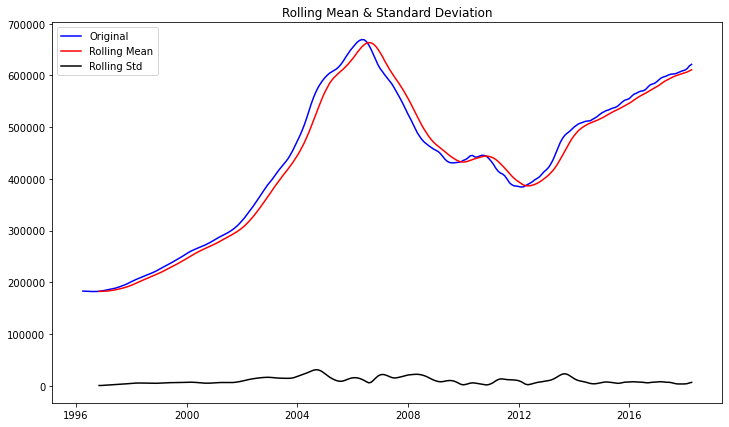

In [62]:
fig = plt.figure(figsize=(12,7))
plt.plot(top10_df2['value'], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [63]:
for i in range(10):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(zip_ts[i].ret.diff().dropna()) #differencing by 12 month for stationarity
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')


ADFuller test p-value for zipcode: 96141
p-value: 6.372408708383532e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 93405
p-value: 7.132708870111328e-09
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 92866
p-value: 1.0822992598658458e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 92101
p-value: 6.688588032966818e-10
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 95441
p-value: 5.945230489199049e-09
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 94546
p-value: 1.261712636851628e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 91754
p-value: 4.06794177445599e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 92860
p-value: 0.0021966709002372324
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcod

In [64]:
#Create individual time series for each of the positive zipcodes
TS_92101 = zip_ts[3].ret.dropna()
TS_92101d = zip_ts[3].ret.diff().dropna()

TS_91754 = zip_ts[6].ret.dropna()
TS_91754d = zip_ts[6].ret.diff().dropna()

TS_92866 = zip_ts[2].ret.dropna()
TS_92866d = zip_ts[2].ret.diff().dropna()

TS_92860 = zip_ts[7].ret.dropna()
TS_92860d = zip_ts[7].ret.diff().dropna()

TS_96141 = zip_ts[0].ret.dropna()
TS_96141d = zip_ts[0].ret.diff().dropna()

TS_95441 = zip_ts[4].ret.dropna()
TS_95441d = zip_ts[4].ret.diff().dropna()

TS_93405 = zip_ts[1].ret.dropna()
TS_93405d = zip_ts[1].ret.diff().dropna()

TS_95818 = zip_ts[8].ret.dropna()
TS_95818d = zip_ts[8].ret.diff().dropna()

TS_93003 = zip_ts[9].ret.dropna()
TS_93003d = zip_ts[9].ret.diff().dropna()

TS_94546 = zip_ts[5].ret.dropna()
TS_94546d = zip_ts[5].ret.diff().dropna()

## Forecasting

### 1. Zipcode 92101: San Diego County - San Diego

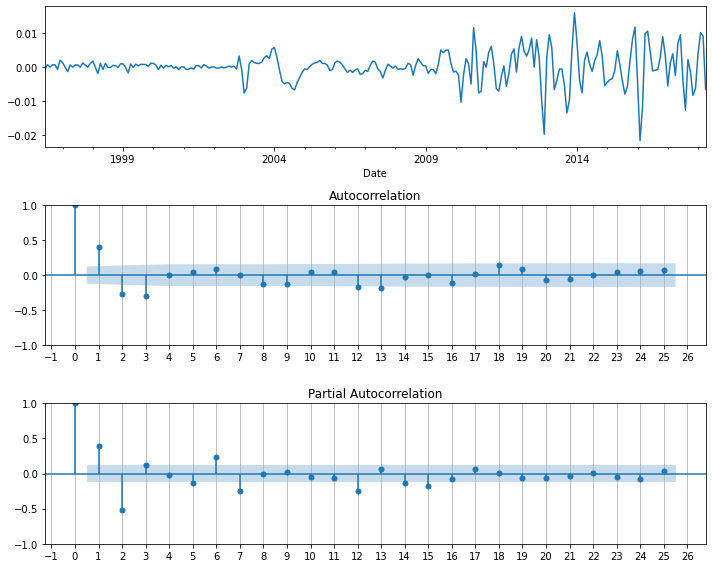

In [65]:
plot_acf_pacf(TS_92101d,lags=25);

In [66]:
pm.auto_arima(TS_92101d,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2187.409, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2101.257, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2151.089, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2198.253, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2103.236, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2190.008, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2193.963, Time=0.31 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2205.221, Time=0.35 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2200.315, Time=0.62 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-2110.345, Time=0.51 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2217.491, Time=1.96 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2191.779, Time=0.30 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2214.227, Time=1.97 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-2153.584, Time=0.61 sec
 ARIM

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

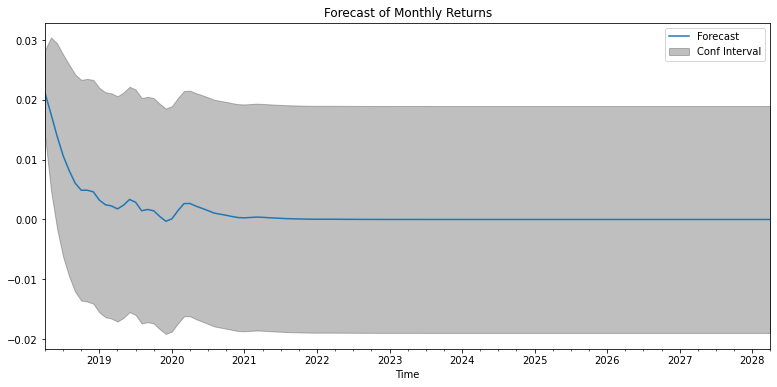

Total expected return in 1 year: 10.47%
Total expected return in 3 years: 14.06%
Total expected return in 5 year: 14.27%
Total expected return in 10 years: 14.27%


In [67]:
pdq = (2, 0, 1)
pdqs = (1, 0, 2, 12)
ret_92101 = forecast_model(TS_92101,pdq=pdq,pdqs=pdqs,zc=92101)

### 2. Zipcode 91754: Los Angeles County - Monterey Park

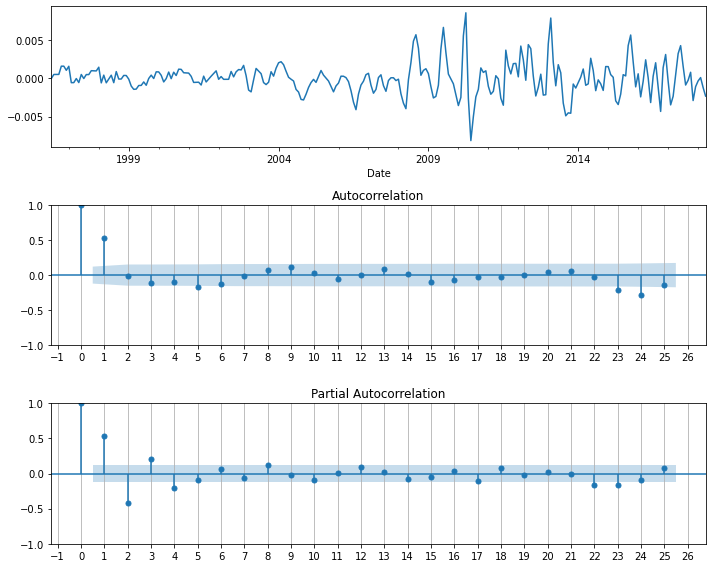

In [68]:
plot_acf_pacf(TS_91754d,lags=25);

In [69]:
pm.auto_arima(TS_91754d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2500.082, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2503.870, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2586.321, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2596.583, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2505.844, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2606.347, Time=0.14 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2604.324, Time=0.35 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2596.071, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2630.902, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2628.893, Time=0.49 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2624.743, Time=0.19 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2624.350, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2588.315, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-2647.300, Time=0.10 sec
 ARIM

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

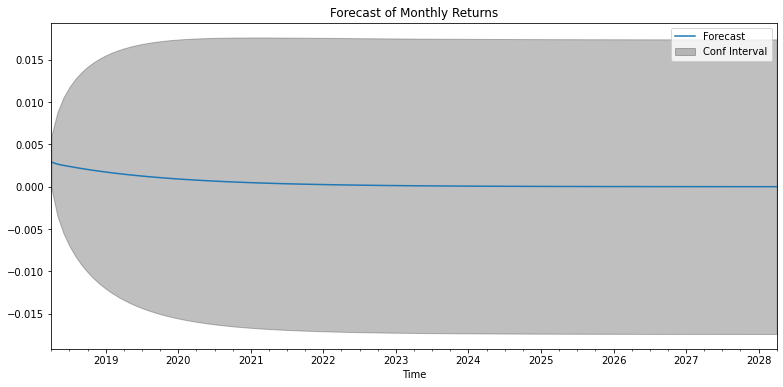

Total expected return in 1 year: 2.6%
Total expected return in 3 years: 4.72%
Total expected return in 5 year: 5.32%
Total expected return in 10 years: 5.54%


In [70]:
pdq = (2, 0, 1)
pdqs = (0, 0, 0, 12)
ret_91754 = forecast_model(TS_91754,pdq=pdq,pdqs=pdqs,zc=91754)

### 3. Zipcode 92860: Riverside County - Norco

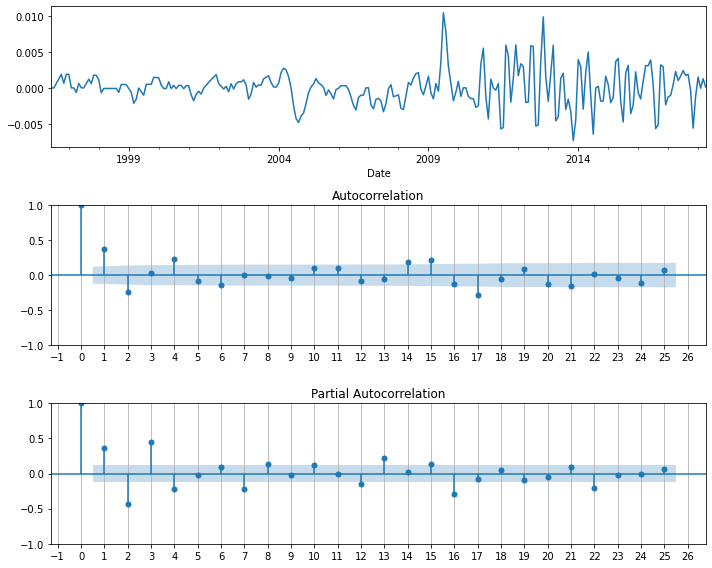

In [71]:
plot_acf_pacf(TS_92860d,lags=25);

In [72]:
pm.auto_arima(TS_92860d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2412.562, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2415.055, Time=0.33 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2452.756, Time=1.59 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2528.244, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2416.942, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2522.581, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2521.375, Time=0.31 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2524.445, Time=0.19 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2543.881, Time=1.97 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-2532.789, Time=1.45 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=-2532.759, Time=2.57 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-2404.598, Time=0.76 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2539.967, Time=2.39 sec
 ARIMA(0,0,

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

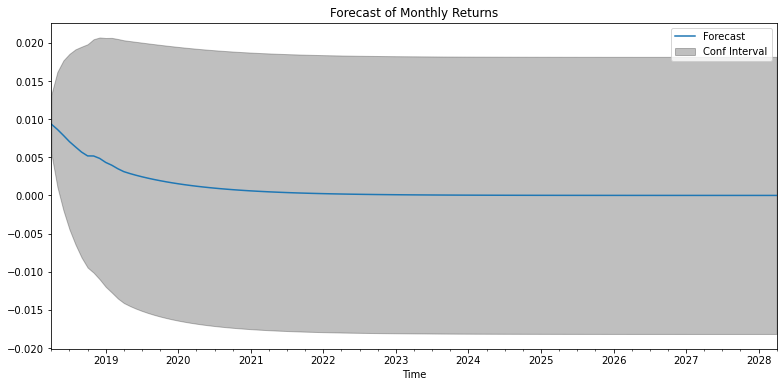

Total expected return in 1 year: 7.43%
Total expected return in 3 years: 11.23%
Total expected return in 5 year: 11.82%
Total expected return in 10 years: 11.93%


In [73]:
pdq = (2, 0, 2)
pdqs = (0, 0, 1, 12)
ret_92860 = forecast_model(TS_92860,pdq=pdq,pdqs=pdqs,zc=92860)

### 4. Zipcode 96141: Placer County - Homewood

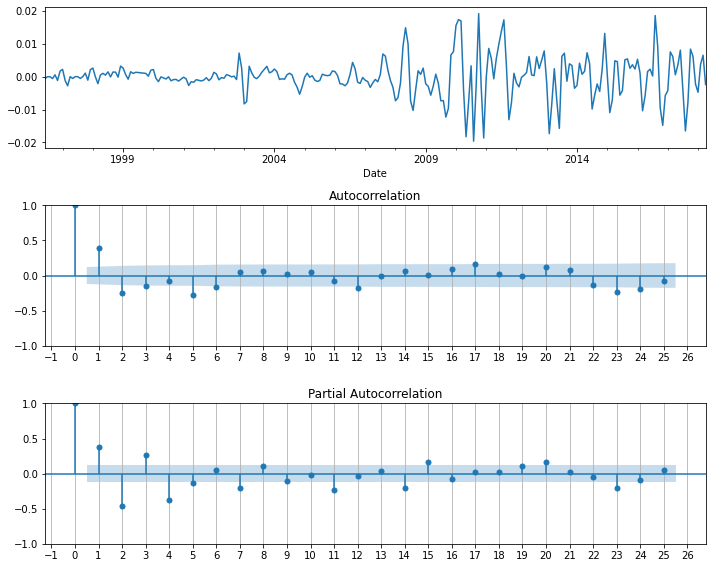

In [74]:
plot_acf_pacf(TS_96141d,lags=25);

In [75]:
pm.auto_arima(TS_96141d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1973.757, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1967.345, Time=0.21 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2016.851, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2085.945, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1969.345, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2075.458, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2080.524, Time=0.13 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2112.062, Time=0.48 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2102.526, Time=0.65 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-2023.178, Time=0.39 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=-2109.295, Time=2.42 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-2052.711, Time=0.64 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=-2115.132, Time=1.23 sec
 ARIMA(1,0,

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

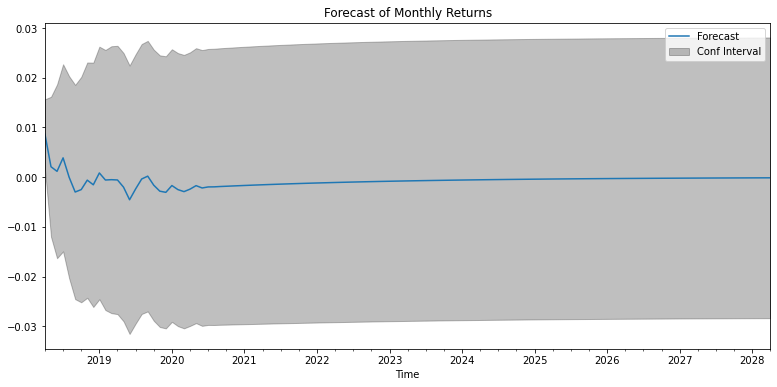

Total expected return in 1 year: 0.8%
Total expected return in 3 years: -3.78%
Total expected return in 5 year: -6.3%
Total expected return in 10 years: -8.28%


In [76]:
pdq = (2, 0, 3)
pdqs = (0, 0, 2, 12)
ret_96141 = forecast_model(TS_96141,pdq=pdq,pdqs=pdqs,zc=96141)

### 5. Zipcode 95441 County: Sonoma County - Geyserville

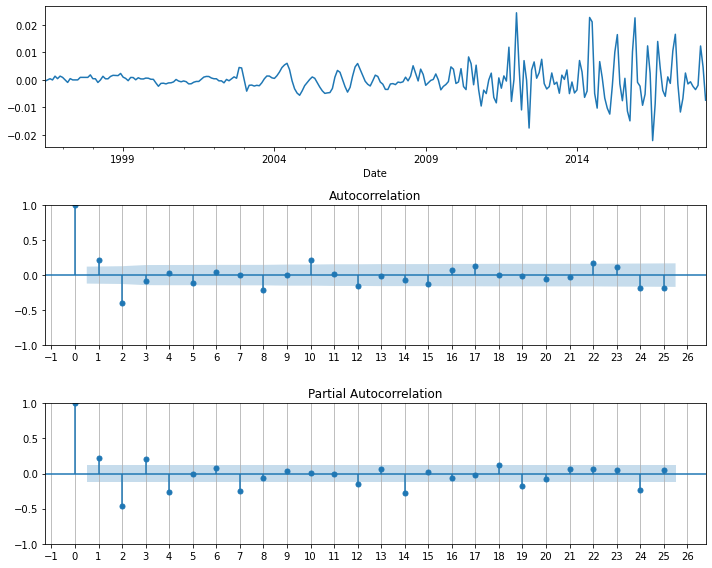

In [77]:
plot_acf_pacf(TS_95441d,lags=25);

In [78]:
pm.auto_arima(TS_95441d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2014.562, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1998.357, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2016.057, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2000.346, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2009.582, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-2031.396, Time=1.27 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-2016.292, Time=0.80 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-2093.136, Time=1.85 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-2080.740, Time=0.20 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=-2099.042, Time=1.24 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-2096.725, Time=0.44 sec
 ARIMA(2,0,0)(2,0,2)[12

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

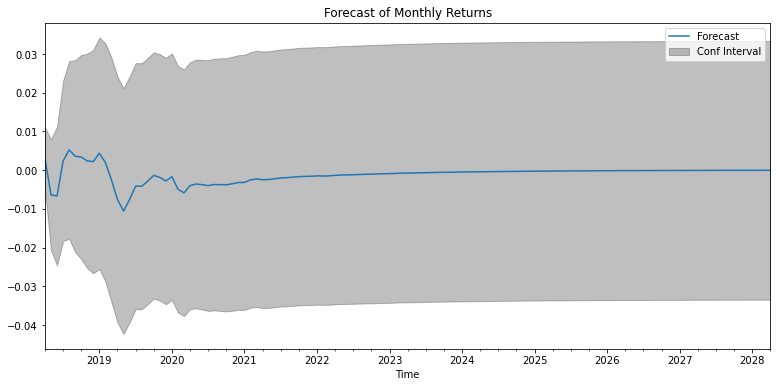

Total expected return in 1 year: 1.3%
Total expected return in 3 years: -8.06%
Total expected return in 5 year: -11.23%
Total expected return in 10 years: -12.58%


In [79]:
pdq = (2, 0, 2)
pdqs = (2, 0, 2, 12)
ret_95441 = forecast_model(TS_95441,pdq=pdq,pdqs=pdqs,zc=95441)

### 6. Zipcode 93405: San Luis Obispo County - San Luis Obispo

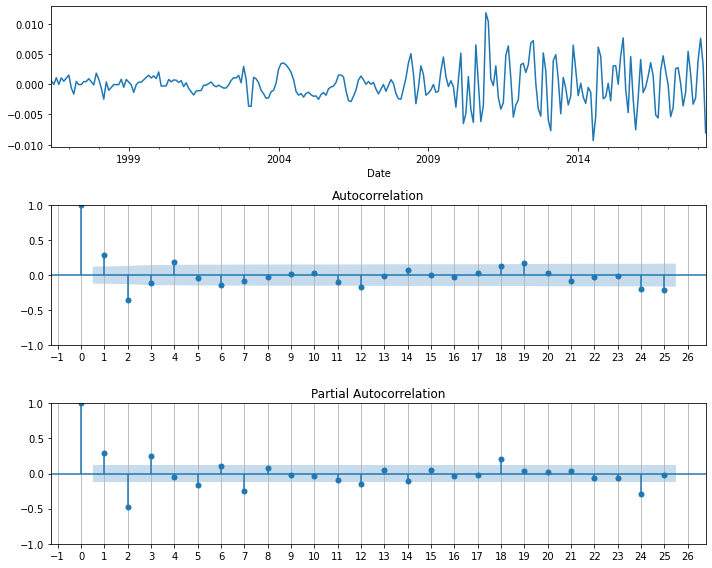

In [80]:
plot_acf_pacf(TS_93405d,lags=25);

In [81]:
pm.auto_arima(TS_93405d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2324.058, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2317.198, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2343.228, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2395.193, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2319.194, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2386.527, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2389.867, Time=0.27 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2414.220, Time=0.84 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2407.679, Time=0.81 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-2346.664, Time=0.58 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2348.885, Time=0.75 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=-2422.672, Time=2.71 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-2394.947, Time=1.63 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=-2337.955, Time=1.59 sec
 ARIM

ARIMA(order=(0, 0, 3), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

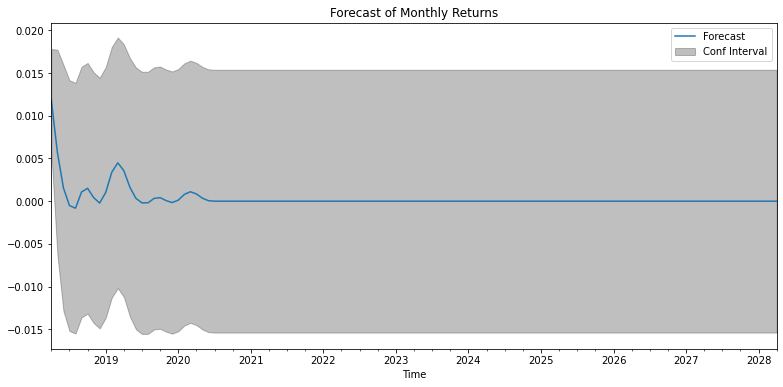

Total expected return in 1 year: 2.98%
Total expected return in 3 years: 3.92%
Total expected return in 5 year: 3.92%
Total expected return in 10 years: 3.92%


In [82]:
pdq = (0, 0, 3)
pdqs = (0, 0, 2, 12)
ret_93405 = forecast_model(TS_93405,pdq=pdq,pdqs=pdqs,zc=93405)

### 7. Zipcode 95818: Sacramento County - Sacramento

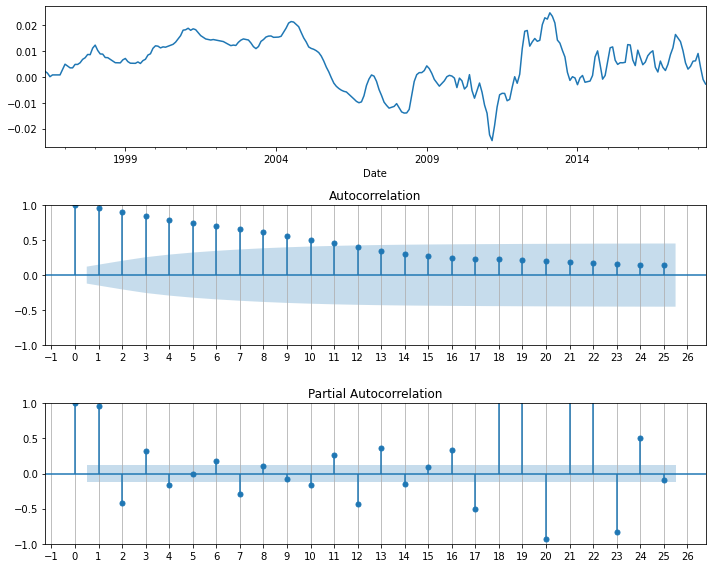

In [83]:
plot_acf_pacf(TS_95818,lags=25);

In [84]:
pm.auto_arima(TS_95818,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1769.399, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1726.900, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2337.912, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2077.241, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1653.966, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2409.108, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-2407.108, Time=0.21 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-2405.158, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-2452.945, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-2392.231, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=-2452.083, Time=0.40 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-2449.291, Time=0.56 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=-2471.496, Time=0.10 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=-2394.074, Time=0.38 sec
 ARIM

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

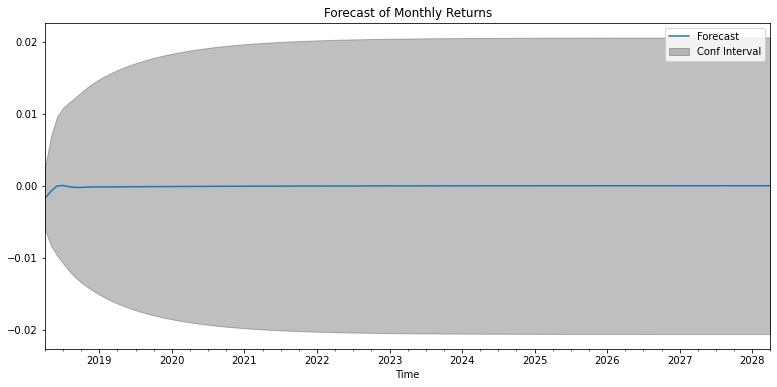

Total expected return in 1 year: -0.4%
Total expected return in 3 years: -0.66%
Total expected return in 5 year: -0.77%
Total expected return in 10 years: -0.83%


In [85]:
pdq = (3, 0, 0)
pdqs = (0, 0, 0, 12)
ret_95818 = forecast_model(TS_95818,pdq=pdq,pdqs=pdqs,zc=95818)

### 8. Zipcode 93003: Ventura County - Ventura

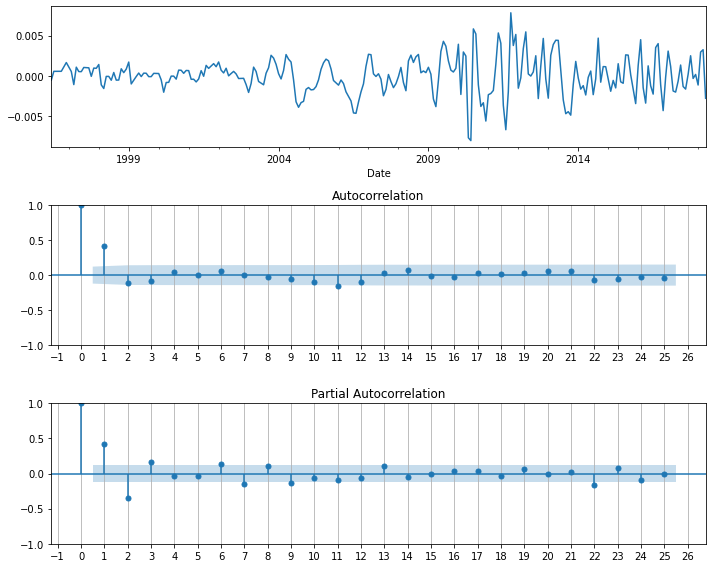

In [86]:
plot_acf_pacf(TS_93003d,lags=25);

In [87]:
pm.auto_arima(TS_93003d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2452.045, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2453.717, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2500.996, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2528.199, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2455.686, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2530.655, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2528.722, Time=0.16 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2525.603, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2510.799, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-2518.694, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2501.420, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-2517.399, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=-2532.654, Time=0.06 sec
 ARIMA(0,0,1)(1,0,0)[12]             : AIC=-2530.718, Time=0.08 sec
 ARIM

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

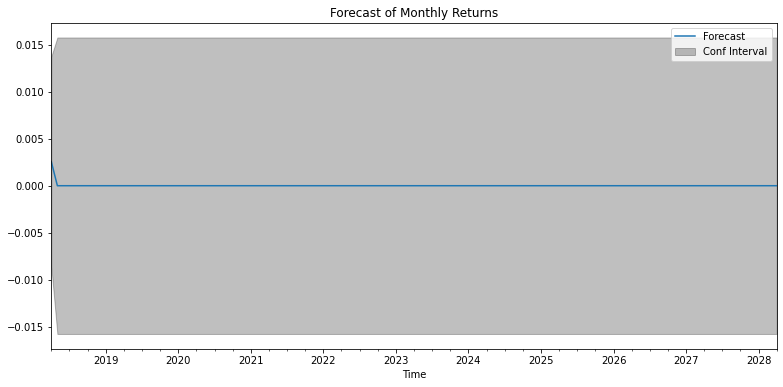

Total expected return in 1 year: 0.26%
Total expected return in 3 years: 0.26%
Total expected return in 5 year: 0.26%
Total expected return in 10 years: 0.26%


In [88]:
pdq = (0, 0, 1)
pdqs = (0, 0, 0, 12)
ret_93003 = forecast_model(TS_93003,pdq=pdq,pdqs=pdqs,zc=93003)

### 9. Zipcode 94546: Alamenda County - Castro Valley

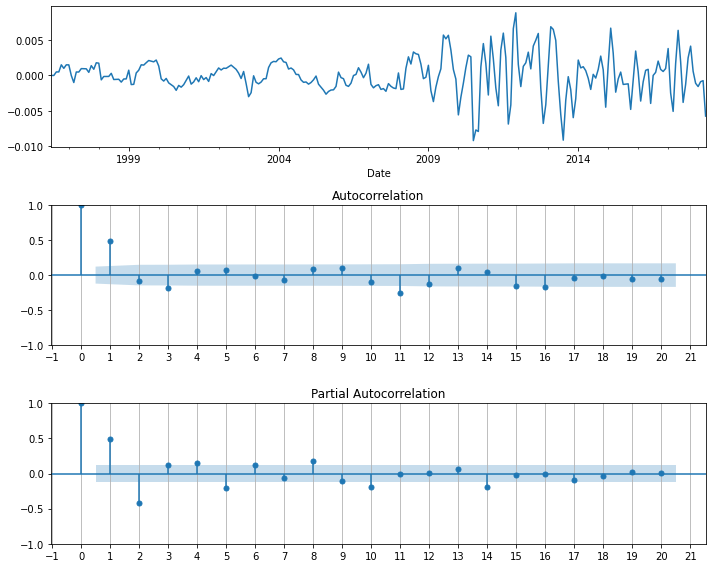

In [89]:
plot_acf_pacf(TS_94546d,lags=20);

In [90]:
pm.auto_arima(TS_94546d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2377.050, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2376.105, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2447.279, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2409.437, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2378.078, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2446.223, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-2453.953, Time=0.90 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-2450.252, Time=0.74 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-2445.672, Time=0.45 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-2383.926, Time=0.58 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-2501.658, Time=0.86 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=-2500.236, Time=0.24 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=-2496.559, Time=0.79 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=-2497.163, Time=0.51 sec
 ARIM

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

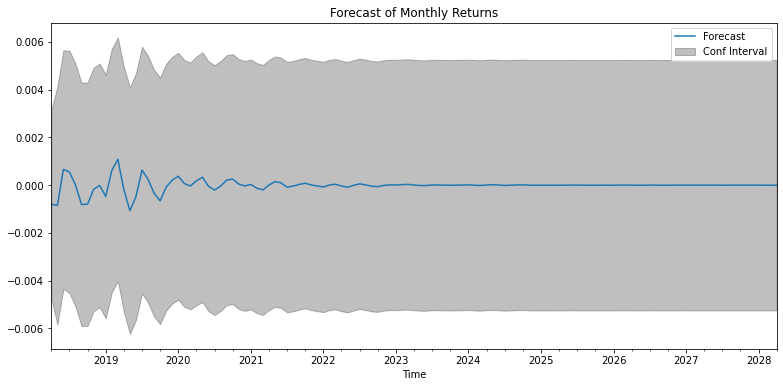

Total expected return in 1 year: -0.1%
Total expected return in 3 years: -0.19%
Total expected return in 5 year: -0.18%
Total expected return in 10 years: -0.18%


In [91]:
pdq = (3, 0, 0)
pdqs = (2, 0, 0, 12)
ret_94546 = forecast_model(TS_94546d,pdq=pdq,pdqs=pdqs,zc=94546)

### 10. Zipcode 92866 Placer county

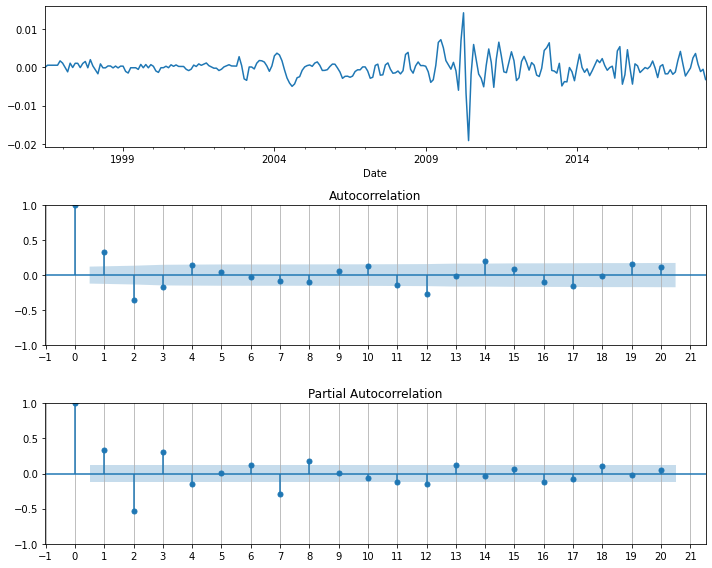

In [99]:
plot_acf_pacf(TS_92866d,lags=20);

In [100]:
pm.auto_arima(TS_92866d,information_criterion='aic',m=12,d=0,
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-2391.400, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2374.893, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2424.396, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2488.801, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-2376.881, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2471.526, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2483.753, Time=0.42 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2488.244, Time=0.50 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-2485.630, Time=0.21 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-2484.540, Time=0.88 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-2396.960, Time=0.36 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2370.483, Time=0.39 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-2317.288, Time=0.59 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-2427.547, Time=0.28 sec
 ARIM

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

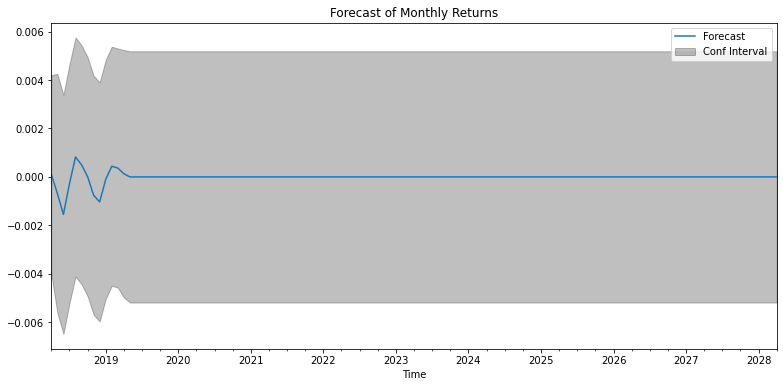

Total expected return in 1 year: -0.22%
Total expected return in 3 years: -0.2%
Total expected return in 5 year: -0.2%
Total expected return in 10 years: -0.2%


In [101]:
pdq = (0, 0, 1)
pdqs = (0, 0, 1, 12)
ret_92866 = forecast_model(TS_92866d,pdq=pdq,pdqs=pdqs,zc=92866)

## Conclusion & Recommendation
Our result shows that below 5 zipcodes have positive ROI, and therefore, I recommend investing in properties in below zip codes. 

**Zip code 92101 (San Diego):** Buy and sell homes within a year. Can wait loger but no true meaning in that after 3 years.


                                   Total expected return in 1 year: 10.47%
                                   Total expected return in 3 year: 14.06%
                                   Total expected return in 5 year: 14.27%
                                   Total expected return in 10 year: 14.27%
                                  
                                
**Zip code 91754 (Los Angeles):** Buy and wait for the next 5-10 years. Although can be sold after 5 year term.

                                  Total expected return in 1 year: 2.6%
                                  Total expected return in 3 year: 4.72%
                                  Total expected return in 5 year: 5.32%
                                  Total expected return in 10 year: 5.54% 
                                  
                                  
**Zip code 92860 (Norco):** Buy and hold for the next 3-5 years. Can wait loger but no true meaning in that after 3 years.

                                 Total expected return in 1 year: 7.43%
                                 Total expected return in 3 year: 11.23%
                                 Total expected return in 5 year: 11.82%
                                 Total expected return in 10 year: 11.93%
                            
**Zip code 93405 (San Luis Obispo):** Buy, flip and sell within a year. Can wait loger but no true meaning in that after 3 years.

                                Total expected return in 1 year: 7.43%
                                Total expected return in 3 year: 11.23%
                                Total expected return in 5 year: 11.82%
                                Total expected return in 10 year: 11.93%

**Zip code 93003 (Ventura):** Buy and hold for atleast 10years. Or forgo this market as the ROI is not too high.

                               Total expected return in 1 year: 0.26%
                               Total expected return in 3 year: 0.26%
                               Total expected return in 5 year: 0.26%
                               Total expected return in 10 year: 50.26%

       

## Further Steps:
1. When forecasting home values, there are many other factors to consider besides the actual values. Consider laying in additional data such as population, tax, education, etc.

2. This data goes only up to 2018. We can potentially explore the data with more recent data.